In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

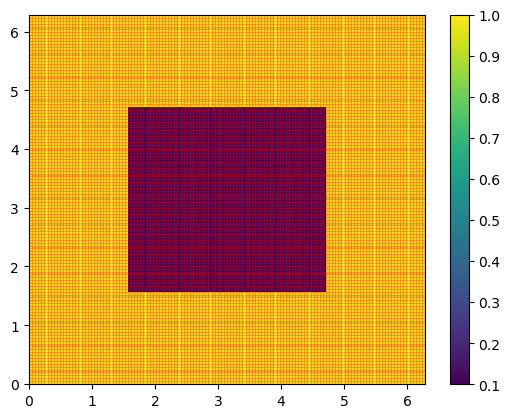

In [19]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

eps=1
def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## Spectral

In [20]:
func1 = lambda x, m, n: torch.cos(m*x[:,0]+n*x[:,1])
func2 = lambda x, m, n: torch.sin(m*x[:,0]+n*x[:,1])
N_x = 8
N_y = 8
test_functions = []

for m in range(N_x):
    for n in range(N_y):
        test_functions.append(lambda x, m=m, n=n: func1(x, m, n))
        test_functions.append(lambda x, m=m, n=n: func2(x, m, n))

test_functions = test_functions[2:]
N_test = len(test_functions)

In [21]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

for i in range(N_test):
    intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
    G[i,i] = intgr

torch.save(G, "G_primal_spectral.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [ ]:
fig, axs = plt.subplots(nrows=32, ncols=N_test//32, figsize=(N_test//32,32), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [22]:
net_primal = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-5, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_primal_{total_params}_{N_test}'}

Number of parameters: 1801


In [13]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [23]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.15489817e+00, mean val. loss:  7.75133491e-01
Epoch: 1 mean train loss:  2.15218067e+00, mean val. loss:  7.75041282e-01
Epoch: 2 mean train loss:  2.14946747e+00, mean val. loss:  7.74949312e-01
Epoch: 3 mean train loss:  2.14675856e+00, mean val. loss:  7.74857402e-01
Epoch: 4 mean train loss:  2.14405394e+00, mean val. loss:  7.74765611e-01
Epoch: 5 mean train loss:  2.14135408e+00, mean val. loss:  7.74673998e-01
Epoch: 6 mean train loss:  2.13865852e+00, mean val. loss:  7.74582505e-01
Epoch: 7 mean train loss:  2.13596773e+00, mean val. loss:  7.74491131e-01
Epoch: 8 mean train loss:  2.13328171e+00, mean val. loss:  7.74399996e-01
Epoch: 9 mean train loss:  2.13060141e+00, mean val. loss:  7.74308980e-01
Epoch: 10 mean train loss:  2.12792492e+00, mean val. loss:  7.74218082e-01
Epoch: 11 mean train loss:  2.12525320e+00, mean val. loss:  7.74127424e-01
Epoch: 12 mean train loss:  2.12258697e+00, mean val. loss:  7.74036825e-01
Epoch: 13 mean train l

In [24]:
np.save(f'NN_library/training_data/square/VSPINN_primal_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

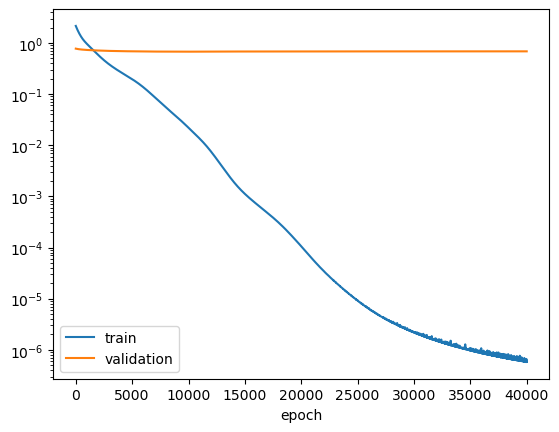

In [25]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [11]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A, H1)

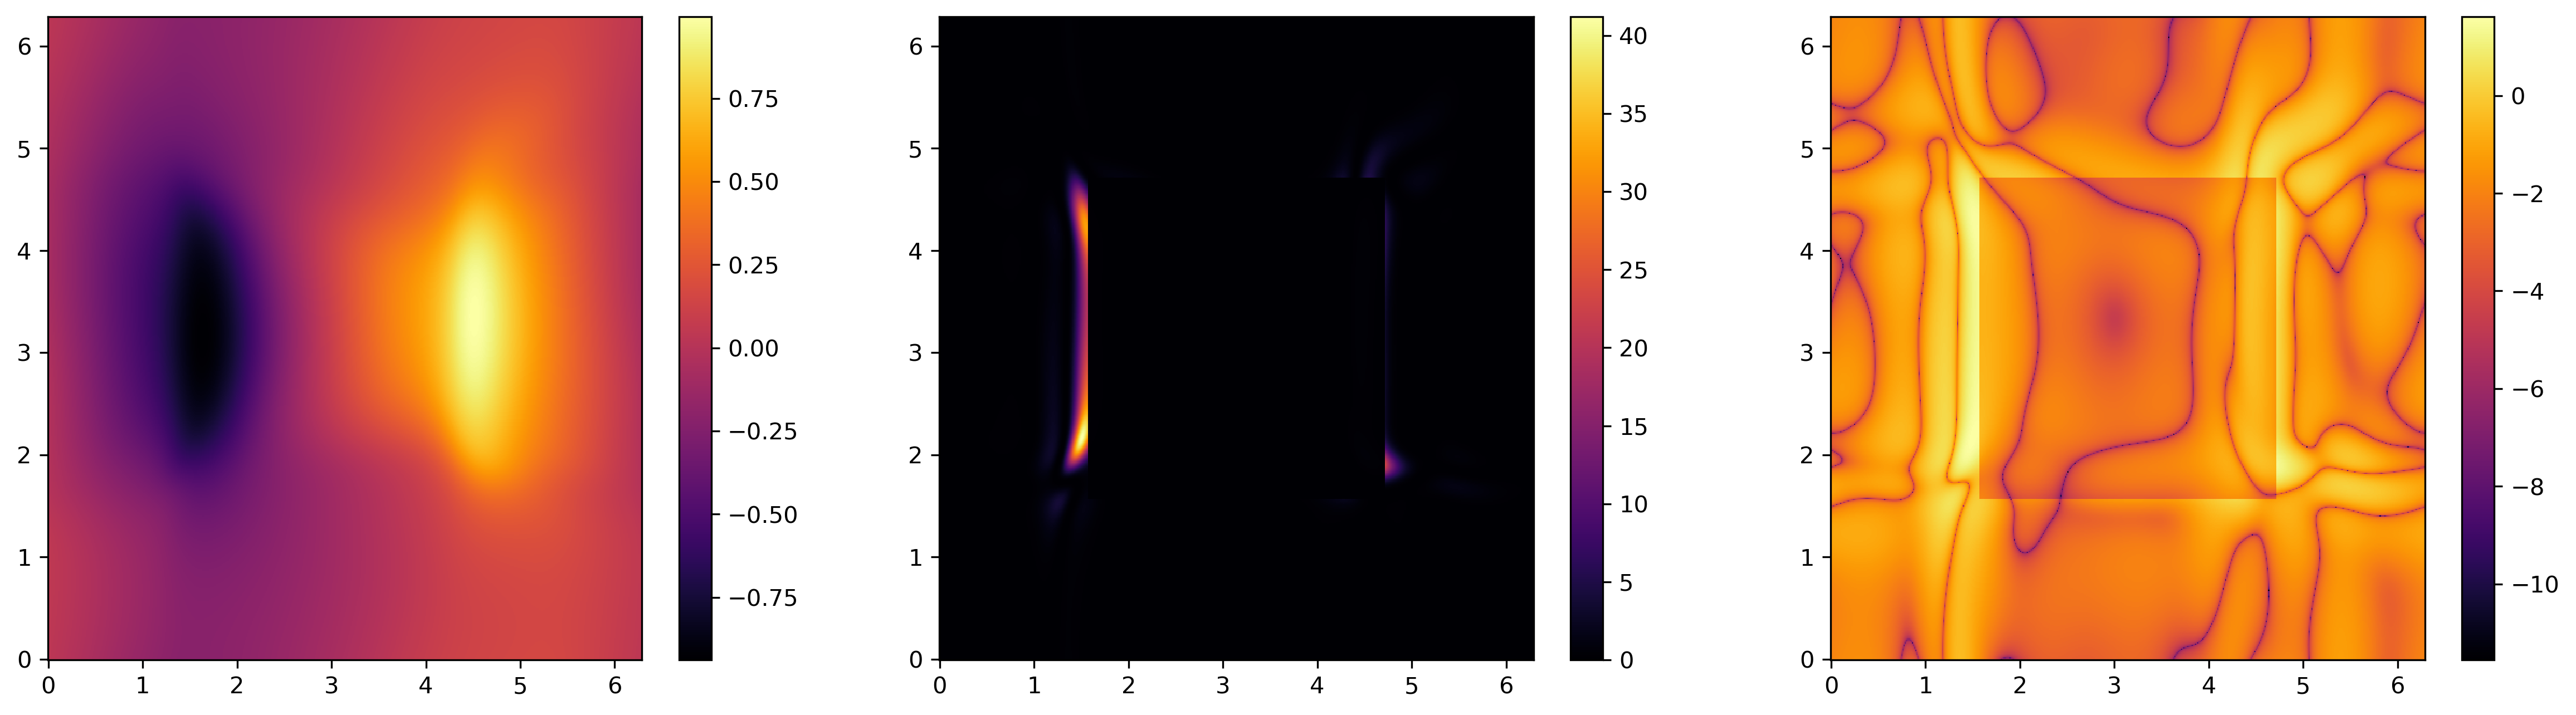

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [27]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach().item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)
bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_VSPINN_{total_params}_{N_test}.npy', (bound_1, bound_2))

0.6861162781715393
0.6780586927583777


# Dual PINN

In [7]:
net_dual = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_dual_{total_params}_{N_test}'}

Number of parameters: 1801


In [16]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [8]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.28148895e+02, mean val. loss:  3.12372744e-01
Epoch: 1 mean train loss:  2.28128174e+02, mean val. loss:  3.12384844e-01
Epoch: 2 mean train loss:  2.28107437e+02, mean val. loss:  3.12396884e-01
Epoch: 3 mean train loss:  2.28086761e+02, mean val. loss:  3.12408954e-01
Epoch: 4 mean train loss:  2.28066132e+02, mean val. loss:  3.12421054e-01
Epoch: 5 mean train loss:  2.28045502e+02, mean val. loss:  3.12433064e-01
Epoch: 6 mean train loss:  2.28024933e+02, mean val. loss:  3.12445104e-01
Epoch: 7 mean train loss:  2.28004303e+02, mean val. loss:  3.12457144e-01
Epoch: 8 mean train loss:  2.27983780e+02, mean val. loss:  3.12469155e-01
Epoch: 9 mean train loss:  2.27963226e+02, mean val. loss:  3.12481135e-01
Epoch: 10 mean train loss:  2.27942734e+02, mean val. loss:  3.12493145e-01
Epoch: 11 mean train loss:  2.27922241e+02, mean val. loss:  3.12505126e-01
Epoch: 12 mean train loss:  2.27901794e+02, mean val. loss:  3.12517077e-01
Epoch: 13 mean train l

In [15]:
np.save(f'NN_library/training_data/square/VSPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

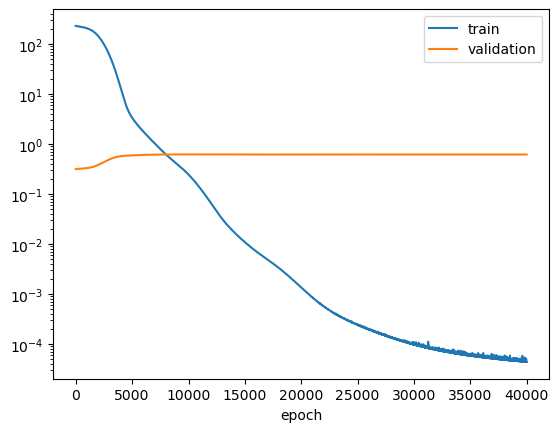

In [14]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [12]:
U2 = net_dual(grid_data).detach().cpu()
error_2, _, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

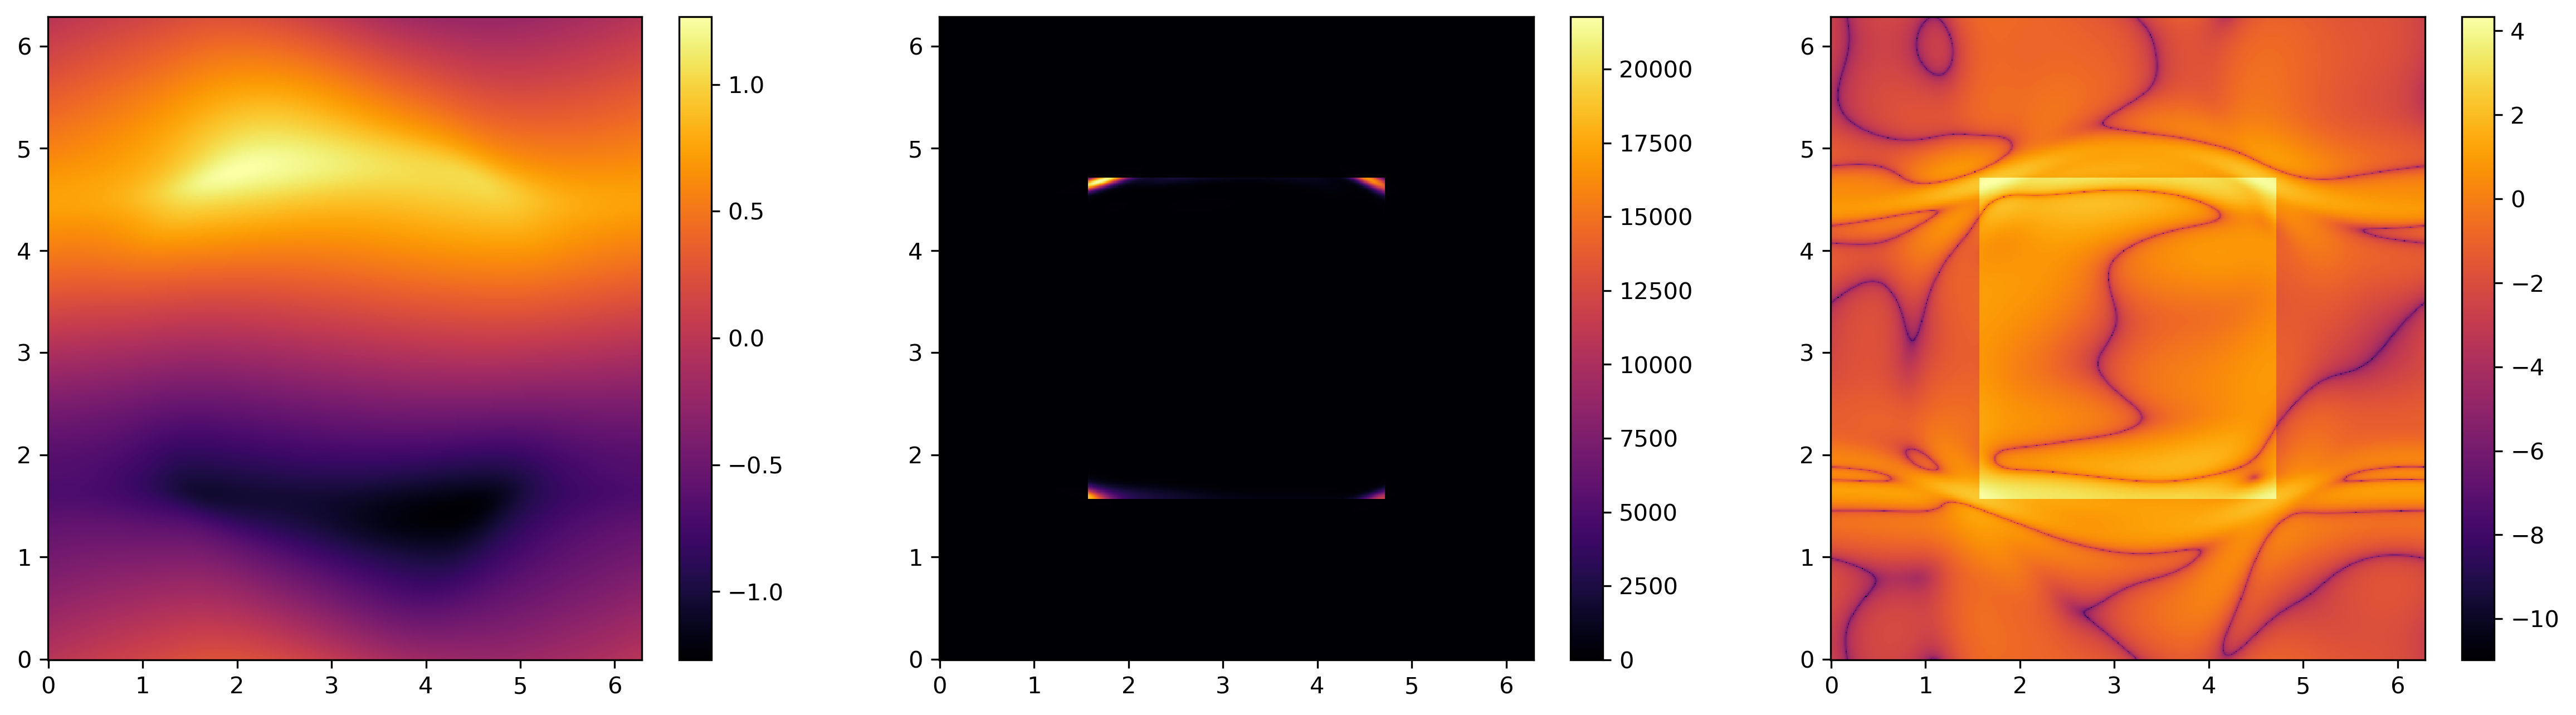

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [16]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach().item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_VSPINN_{total_params}_{N_test}.npy', (1/bound_1, bound_2))

0.6117486758621162
0.602226494814352
